<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2024TeamC/blob/main/Code/DWH_GeoVisualisierung_HS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kursarbeit Datenmanagement und -Archivierung WS 23/24**

Master-Code Name-CALICO:MA


**Explorative Datenanalyse**

> Laden Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
import folium
from folium import plugins

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



> Verbindung zur Datenbank



In [3]:
#connect to DB
#conn = sqlite3.connect('/content/drive/MyDrive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/datawarehouse_new.db')
conn = sqlite3.connect('/content/drive/MyDrive/calico_ma_repo/Data/CALICO_MA_Database/CALICO_MA.db')
cur = conn.cursor()

print("Datenbank wurde erfolgreich geöffnet")

Datenbank wurde erfolgreich geöffnet


In [4]:
print(pd.read_sql_query('''
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
     ''', conn))

            name
0     encounters
1    facts_table
2  immunizations
3    medications
4   observations
5       patients
6     procedures



> Laden die Daten aus der Datenbank in die DataFrames für die weitere Analyse



In [5]:
df_encounters = pd.read_sql_query("SELECT * FROM encounters", conn)
df_facts_table = pd.read_sql_query("SELECT * FROM facts_table", conn)
df_immunizations = pd.read_sql_query("SELECT * FROM immunizations", conn)
df_medications = pd.read_sql_query("SELECT * FROM medications", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_patients = pd.read_sql_query("SELECT * FROM patients", conn)
df_procedures = pd.read_sql_query("SELECT * FROM procedures", conn)

cancer_type
Breast_Cancer        1019
Colorectal_Cancer    1035
Lung_Cancer          1030
Name: Id, dtype: int64


<Axes: xlabel='cancer_type'>

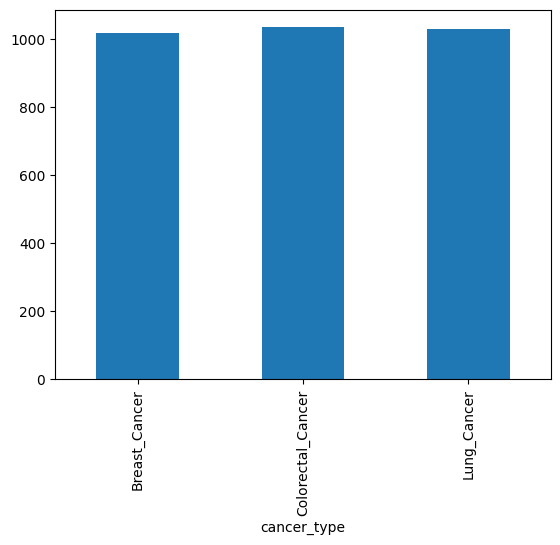

In [6]:
df2 = df_patients.groupby(['cancer_type'])['Id'].count()
print(df2)
df2.plot.bar()

In [7]:
# Überprüfung der facts_table
df3 = df_facts_table.head(3)
print(df3)

     cancer_type                            patient_ID encounter_ID  \
0  Breast_Cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   
1  Breast_Cancer  073d8e80-ff90-1c8d-57e4-29bfca52c87f         None   
2  Breast_Cancer  e1ff7e68-4097-9faf-514d-e4cfcfdf252e         None   

   patient_LAT  patient_LON  patient_HEALTHCARE_EXPENSES  \
0    42.359926   -71.113260                   1475230.00   
1    42.257845   -72.026317                   1489125.00   
2    42.204290   -71.818449                     57142.44   

   patient_HEALTHCARE_COVERAGE patient_BIRTHDATE observations_CODE  \
0                      4244.64        1956-06-22              QALY   
1                      4016.36        1964-08-28              QALY   
2                      2103.20        1998-08-28              QALY   

  observations_VALUE     observations_DATE  observations_AGE  \
0                 63  2020-06-22T10:47:46Z                64   
1                 55  2020-08-28T16:45:45Z                56   
2

Abbildungen

1.   Kosten fur jeder krebsarten (Insgesamt)
2.   Kosten fur jeder krebsarten (getrennt)
3.   Life quality (QALY) mit kosten korrelieren (Insgesamt) (death date not available)
4.   Life quality (QALY) mit kosten korrelieren (getrennt)
5.   Verhaltnis QALY - aktuelle alter (von BIRTHDATE (patients))
6.   Statistiche auswertung

##Gesamte Kosten für jede Krebsart


**Einlesen des Life costs und der Cancer costs für jede Krebsart**

In [8]:
cur.execute('''
          SELECT
        f.cancer_type,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_costs,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS cancer_costs
        FROM facts_table f
;''')

df_Costs = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'life_costs', 'cancer_costs'])


**Darstellung der gesamten Life Kostenverteilung (aggregated values, with confidence intervals)**

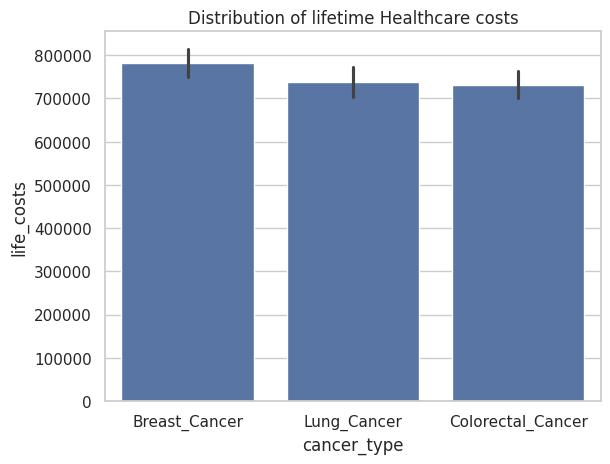

In [9]:
sns.set_theme(style="whitegrid")

g = sns.barplot(
    data=df_Costs, x="cancer_type", y="life_costs").set_title("Distribution of lifetime Healthcare costs")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Lifetime_costs_for_all.png", format='png')

**Darstellung der gesamten Cancer Kostenverteilung (aggregated values, with confidence intervals)**

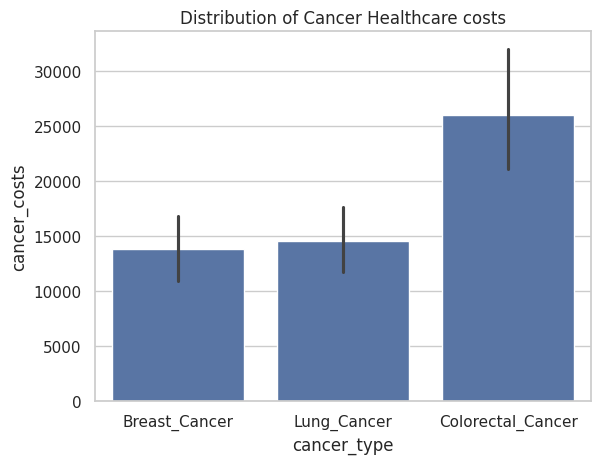

In [10]:
sns.set_theme(style="whitegrid")

g = sns.barplot(
    data=df_Costs, x="cancer_type", y="cancer_costs").set_title("Distribution of Cancer Healthcare costs")
plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_for_all.png", format='png')

## Kosten vs. QALY Werte für alle Krebsarten

QALY wird in den csv Dateien als Jahre in voller Gesundheit. Wir wollen QALY als Werte zwischen 0 und 1. Deshalb wird er hier berechnet als Verhältnis zwischen observation_VALUE und Alter zum Zeitpunkt der Observation. Nur volljährige Patienten werden berücksichtigt.

In [11]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY"
        AND f.observations_AGE > 18  AND f.observations_AGE >= f.observations_VALUE
;''')

df_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
df3 = df_QALY.head(3)
print(df3)



     cancer_type        LAT        LON  QALY  Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY   64   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY   56   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY   22   21.0   0.954545   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  


## Frequency of QALY Values in database

Vor der Auswertung der Daten, wird die Verteilung der vorhandenen QALY Werten  für jede Krebsart angezeigt:

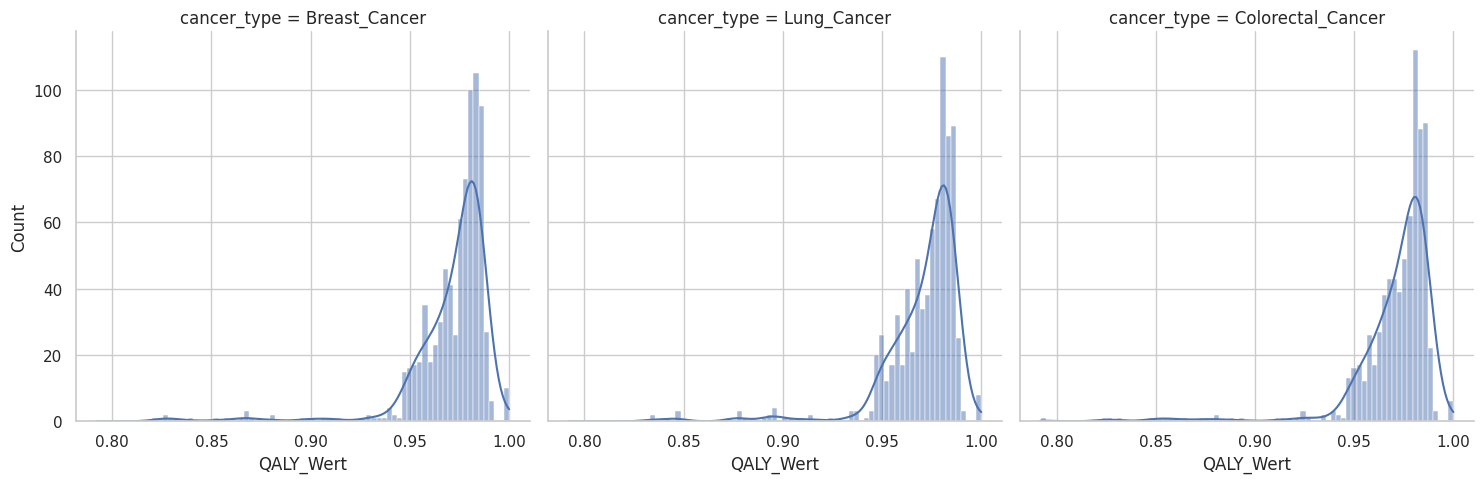

In [12]:
sns.set_theme(style="whitegrid")

g = sns.displot(
    data=df_QALY, x="QALY_Wert", col="cancer_type", kind = "hist", kde=True)

## Availability of Data vs. Age

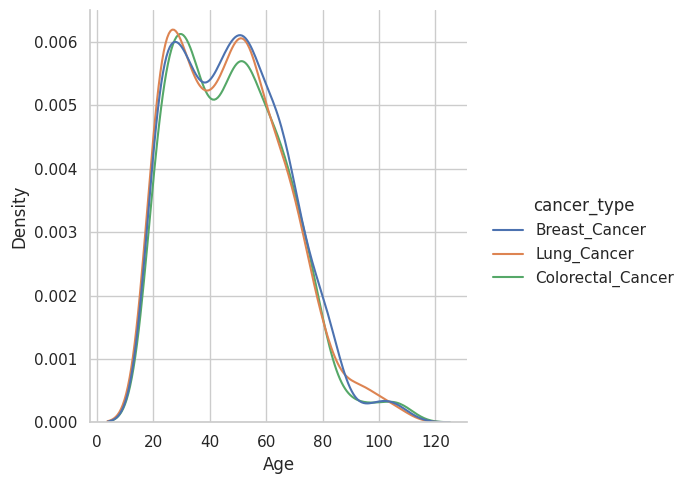

In [13]:
g = sns.displot(
    data=df_QALY, x="Age", hue="cancer_type", kind="kde")

## Geografische Verteilung

In [14]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_p = df_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_p)):
    folium.RegularPolygonMarker(coordinates_p[i], radius = 1, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa


In [15]:
map_massa.save("/content/drive/MyDrive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/Map_for_all.png")

## Cancer costs vs. Age

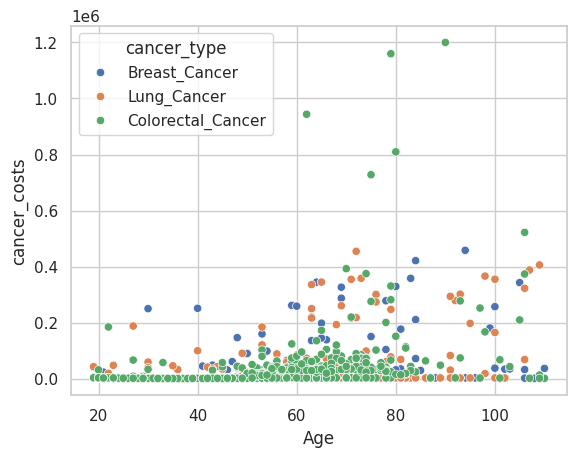

In [16]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="Age", y="cancer_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_age.png", format='png')

## Life costs vs. Age

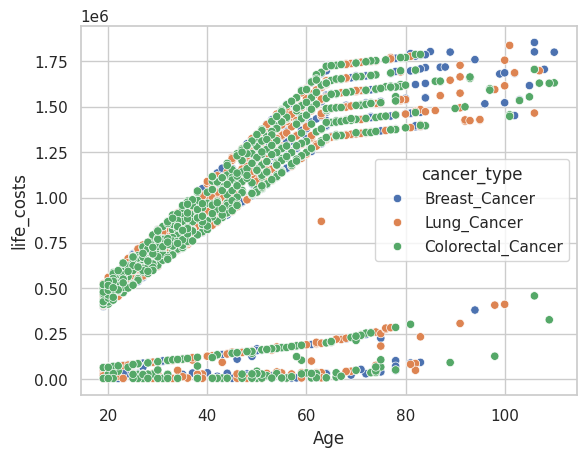

In [17]:
g = sns.scatterplot(
    data=df_QALY, x="Age", y="life_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_age.png", format='png')

## Cancer costs vs. QALY

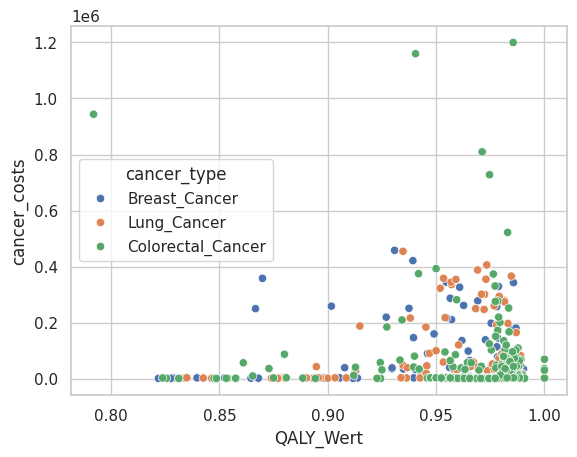

In [18]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="cancer_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')

## Life costs vs. QALY

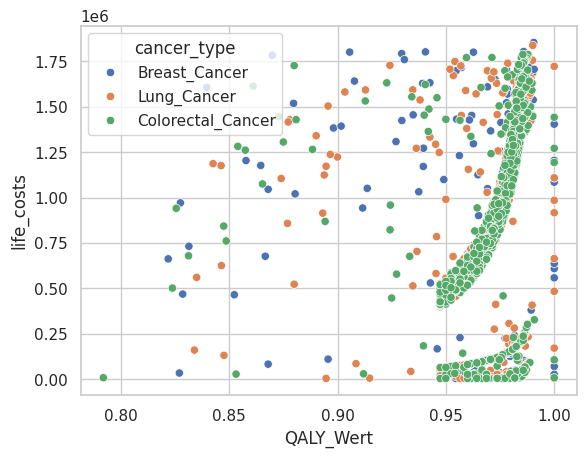

In [19]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="life_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY.png", format='png')

# Lung Patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Lung Cancer Patienten**

In [20]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "lung_cancer"
        AND f.observations_AGE > 18 AND f.observations_AGE >= f.observations_VALUE
;''')

df_lung_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
#result = df_lung.head(50)
#print(result)




In [21]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_lung = df_lung_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_lung)):
    folium.RegularPolygonMarker(coordinates_lung[i], radius = 3, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa

**Verteilung der vorhandenen QALY Werte bei Lungen Patienten**

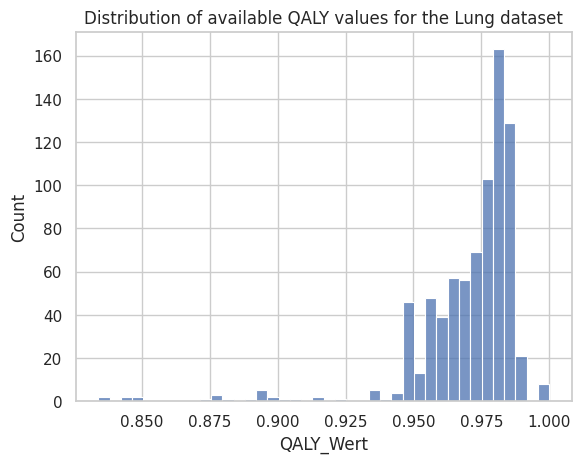

In [22]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_lung_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Lung dataset")

**Cancer Kosten als Funktion vom QALY für Lung Patienten**

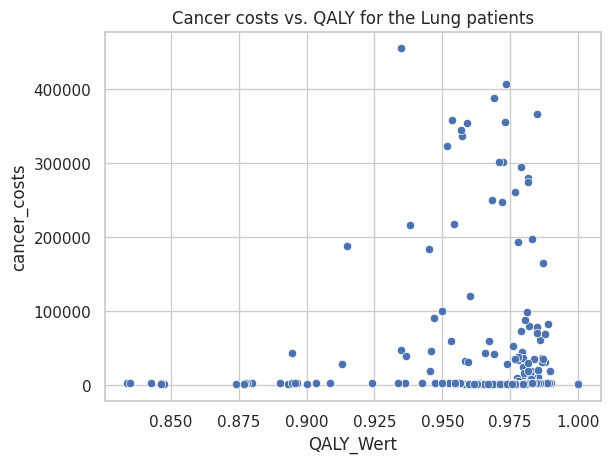

In [23]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Lung.png", format='png')


**Life Kosten als Funktion vom QALY für Lung Patienten**

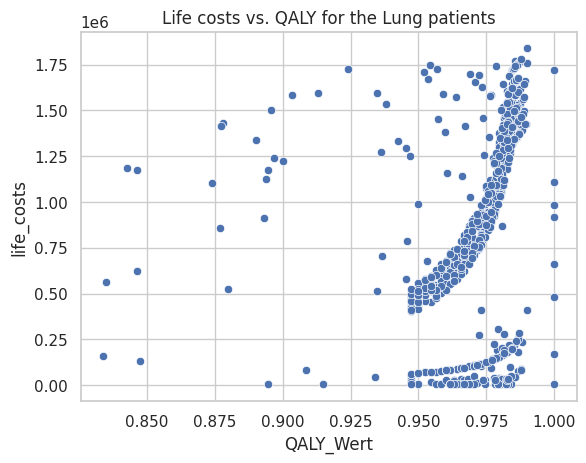

In [24]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Lung.png", format='png')

# Colorectal patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Colorectal Cancer Patienten**

In [25]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "colorectal_cancer"
        AND f.observations_AGE > 18 AND f.observations_AGE >= f.observations_VALUE
;''')

df_colorectal_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_colorectal_QALY.head(5)
print(result)

         cancer_type        LAT        LON  QALY  Age  Value  QALY_Wert  \
0  Colorectal_Cancer  42.260377 -72.582313  QALY   37   36.0   0.972973   
1  Colorectal_Cancer  42.296278 -71.052652  QALY   39   38.0   0.974359   
2  Colorectal_Cancer  41.753744 -71.098516  QALY   35   34.0   0.971429   
3  Colorectal_Cancer  42.405090 -72.554248  QALY   52   51.0   0.980769   
4  Colorectal_Cancer  42.656468 -71.160367  QALY   51   50.0   0.980392   

   life_costs  cancer_costs  
0   904391.44       1219.24  
1   811891.44        949.56  
2   721662.28       1219.24  
3    18674.72       2039.64  
4  1114095.56       2320.68  


In [26]:
coordinates_colorectal = df_colorectal_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_colorectal)):
    folium.RegularPolygonMarker(coordinates_colorectal[i], radius = 3, fill_color = "blue", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa

**Verteilung der vorhandenen QALY Werte bei Colorectal Patienten**

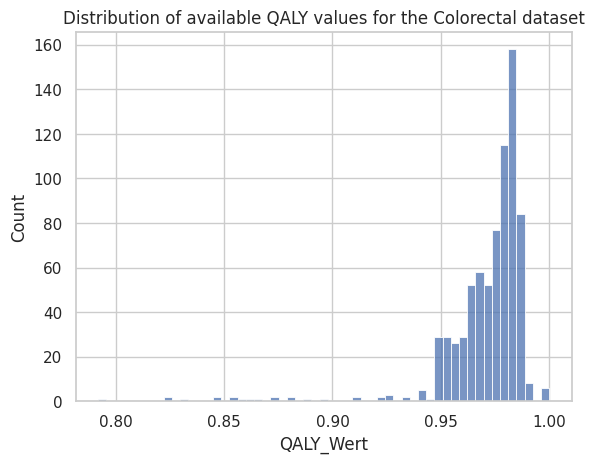

In [27]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_colorectal_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Colorectal dataset")

**Cancer Kosten als Funktion vom QALY für Colorectal Patienten**

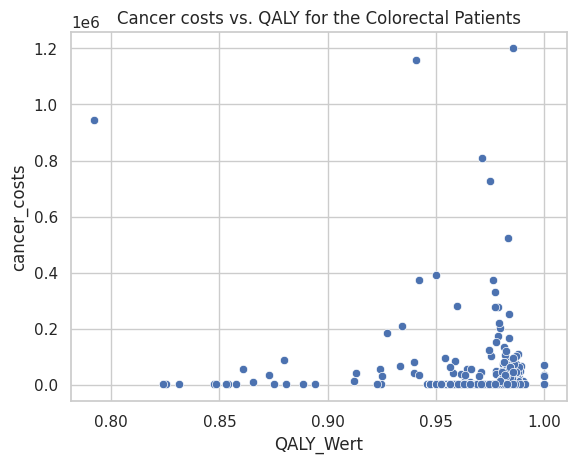

In [28]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Colorectal Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Colorectal.png", format='png')

**Life Kosten als Funktion vom QALY für Colorectal Patienten**

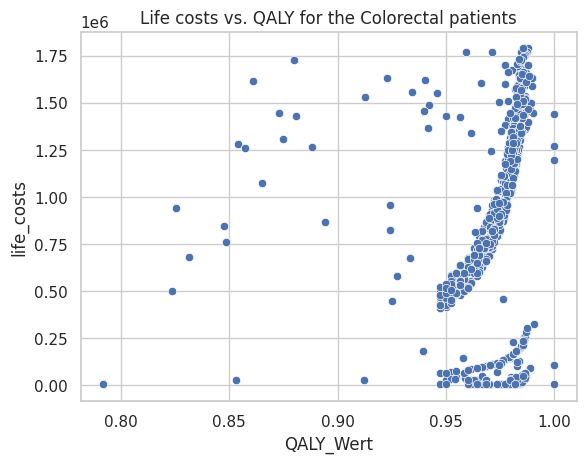

In [29]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Colorectal patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Colorectal.png", format='png')

# Breast patients

**Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Breast Cancer Patienten**

In [30]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.observations_CODE LIKE "QALY" AND f.cancer_type LIKE "breast_cancer"
        AND f.observations_AGE > 18 AND f.observations_AGE >= f.observations_VALUE
;''')

df_breast_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_breast_QALY.head(5)
print(result)

     cancer_type        LAT        LON  QALY  Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY   64   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY   56   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY   22   21.0   0.954545   
3  Breast_Cancer  42.347571 -71.041350  QALY   29   28.0   0.965517   
4  Breast_Cancer  42.522343 -71.147480  QALY   56   55.0   0.982143   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  
3   787203.96       1230.60  
4  1429741.36       2579.00  


In [31]:
coordinates_breast = df_breast_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_breast)):
    folium.RegularPolygonMarker(coordinates_breast[i], radius = 3, fill_color = "green", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa

**Verteilung der vorhandenen QALY Werte bei Breast Patienten**

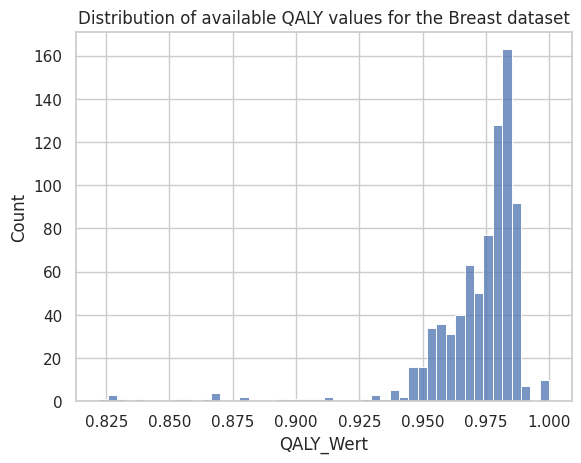

In [32]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_breast_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Breast dataset")

**Cancer Kosten vs. QALY Werte für Breast Cancer Patienten**

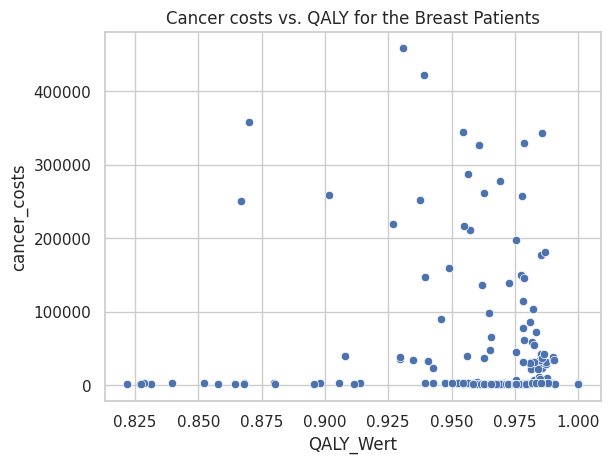

In [33]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Breast Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Breast.png", format='png')

**Life Kosten als Funktion vom QALY für Breast Patienten**

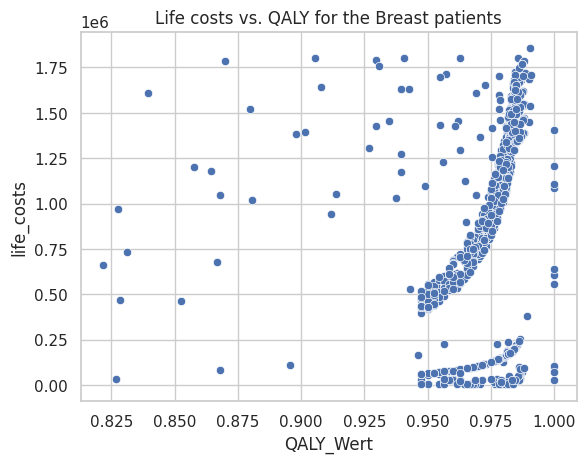

In [34]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Breast patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Breast.png", format='png')